## Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import classification_report, make_scorer
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor


## Importing dataset

In [2]:
df = pd.read_excel('premiums_rest.xlsx')

In [3]:
#First few rows of dataset
df.head(5)

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,10L - 25L,14,Diabetes,Bronze,15610


## Data Cleaning

In [4]:
#Checking for any null rows
print('Size of the dataframe: ', df.shape)
df.isna().sum()


Size of the dataframe:  (29904, 13)


Age                      0
Gender                   0
Region                   0
Marital_status           0
Number Of Dependants     0
BMI_Category             0
Smoking_Status           9
Employment_Status        1
Income_Level             9
Income_Lakhs             0
Medical History          0
Insurance_Plan           0
Annual_Premium_Amount    0
dtype: int64

In [5]:
# Removing rows with missing values (only a few), as imputing them isn't necessary and may introduce noise
df.dropna(inplace=True)
print('Size of the new dataframe: ', df.shape)

Size of the new dataframe:  (29886, 13)


In [6]:
#Converting any dependents to a positive number
df['Number Of Dependants'] = abs(df['Number Of Dependants'])

In [7]:
df.describe()

,Age,Number Of Dependants,Income_Lakhs,Annual_Premium_Amount
count,29886.000000,29886.000000,29886.000000,29886.000000
mean,43.396105,2.385933,23.364184,20892.303821
std,13.412657,1.421137,24.740339,6936.813440
min,26.000000,0.000000,1.000000,3625.000000
25%,34.000000,1.000000,7.000000,15697.250000
50%,42.000000,3.000000,17.000000,20489.000000
75%,52.000000,3.000000,32.000000,26360.000000
max,356.000000,5.000000,930.000000,43471.000000


In [8]:
#Checking how many rows have age greater than 100
df[df['Age']>100].shape

#Dropping rows where age is greater than 100
df = df[df['Age'] <= 100]

In [9]:
df.describe()

,Age,Number Of Dependants,Income_Lakhs,Annual_Premium_Amount
count,29828.000000,29828.000000,29828.000000,29828.000000
mean,43.095380,2.387790,23.371530,20901.900563
std,11.041991,1.420641,24.751262,6928.457636
min,26.000000,0.000000,1.000000,6538.000000
25%,34.000000,1.000000,7.000000,15706.000000
50%,42.000000,3.000000,17.000000,20496.000000
75%,52.000000,3.000000,32.000000,26361.000000
max,72.000000,5.000000,930.000000,43471.000000


In [10]:
#Dropping valyes where Income is unreasonable
def get_iqr_bounds(col):
    Q1, Q3 = col.quantile([0.25, 0.75])
    IQR = Q3-Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

lower, upper = get_iqr_bounds(df['Income_Lakhs'])
lower, upper

quantile_thresold = df['Income_Lakhs'].quantile(0.999)
quantile_thresold

df1 = df[df['Income_Lakhs'] <= quantile_thresold].copy()
df1.shape

(29822, 13)

In [11]:
print("Shape of new dataframe:", df1.shape)
df1.describe()

Shape of new dataframe: (29822, 13)


,Age,Number Of Dependants,Income_Lakhs,Annual_Premium_Amount
count,29822.000000,29822.000000,29822.000000,29822.000000
mean,43.094896,2.387734,23.226343,20900.689223
std,11.042430,1.420644,22.455408,6928.192115
min,26.000000,0.000000,1.000000,6538.000000
25%,34.000000,1.000000,7.000000,15705.250000
50%,42.000000,3.000000,17.000000,20495.500000
75%,52.000000,3.000000,32.000000,26360.000000
max,72.000000,5.000000,100.000000,43471.000000


In [12]:
print(df1.columns.tolist())

['Age', 'Gender', 'Region', 'Marital_status', 'Number Of Dependants', 'BMI_Category', 'Smoking_Status', 'Employment_Status', 'Income_Level', 'Income_Lakhs', 'Medical History', 'Insurance_Plan', 'Annual_Premium_Amount']


In [13]:
categorical_cols = ['Gender', 'Region', 'Marital_status', 'BMI_Category', 'Smoking_Status', 'Employment_Status', 'Income_Level', 'Medical History', 'Insurance_Plan']
for col in categorical_cols:
    print(col, ":", df1[col].unique())

Gender : ['Male' 'Female']
Region : ['Northwest' 'Southeast' 'Northeast' 'Southwest']
Marital_status : ['Unmarried' 'Married']
BMI_Category : ['Normal' 'Obesity' 'Overweight' 'Underweight']
Smoking_Status : ['No Smoking' 'Regular' 'Occasional' 'Does Not Smoke' 'Not Smoking'
 'Smoking=0']
Employment_Status : ['Salaried' 'Self-Employed' 'Freelancer']
Income_Level : ['<10L' '10L - 25L' '> 40L' '25L - 40L']
Medical History : ['Diabetes' 'High blood pressure' 'No Disease'
 'Diabetes & High blood pressure' 'Thyroid' 'Heart disease'
 'High blood pressure & Heart disease' 'Diabetes & Thyroid'
 'Diabetes & Heart disease']
Insurance_Plan : ['Bronze' 'Silver' 'Gold']


In [14]:
df1['Smoking_Status'] = df1['Smoking_Status'].map({
    'Not Smoking': 'No Smoking',
    'Does Not Smoke': 'No Smoking',
    'Smoking=0': 'No Smoking'
}).fillna(df1['Smoking_Status'])


df1['Smoking_Status'].unique()

array(['No Smoking', 'Regular', 'Occasional'], dtype=object)

## Feature Engineering for Diabetes column 

In [15]:
# Split 'Medical History' into two columns
df1[['disease1', 'disease2']] = (
    df1['Medical History'].str.split(" & ", expand=True)
    .apply(lambda x: x.str.lower())
)

# Avoid inplace and chained assignment warnings
df1['disease1'] = df1['disease1'].fillna('none')
df1['disease2'] = df1['disease2'].fillna('none')

# Define risk scores
risk_scores = {
    "diabetes": 6,
    "heart disease": 8,
    "high blood pressure": 6,
    "thyroid": 5,
    "no disease": 0,
    "none": 0
}

# Calculate total risk score
df1['total_risk_score'] = 0
for disease in ['disease1', 'disease2']:
    df1['total_risk_score'] += df1[disease].map(risk_scores)

# Normalize to [0, 1]
max_score = df1['total_risk_score'].max()
min_score = df1['total_risk_score'].min()
df1['normalized_risk_score'] = (df1['total_risk_score'] - min_score) / (max_score - min_score)

df1.sample(5)


,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount,disease1,disease2,total_risk_score,normalized_risk_score
4574,37,Male,Northwest,Married,3,Overweight,Regular,Salaried,10L - 25L,23,High blood pressure,Silver,20571,high blood pressure,none,6,0.428571
23687,39,Male,Northwest,Married,3,Normal,Regular,Salaried,<10L,1,Heart disease,Silver,22754,heart disease,none,8,0.571429
5705,44,Female,Northwest,Married,5,Obesity,Occasional,Salaried,25L - 40L,39,High blood pressure,Silver,20323,high blood pressure,none,6,0.428571
19994,56,Female,Southeast,Unmarried,0,Obesity,No Smoking,Self-Employed,10L - 25L,17,Diabetes,Gold,30401,diabetes,none,6,0.428571
24252,43,Female,Southwest,Married,2,Normal,Occasional,Self-Employed,> 40L,89,Heart disease,Silver,20373,heart disease,none,8,0.571429


In [16]:
df1['Insurance_Plan'] = df1['Insurance_Plan'].map({'Bronze': 1, 'Silver': 2, 'Gold': 3})
df1['Income_Level'] = df1['Income_Level'].map({'<10L':1, '10L - 25L': 2, '25L - 40L':3, '> 40L':4})

In [17]:
df1.sample(5)

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount,disease1,disease2,total_risk_score,normalized_risk_score
7838,31,Female,Northwest,Married,2,Overweight,No Smoking,Salaried,1,9,Diabetes & Thyroid,1,13126,diabetes,thyroid,11,0.785714
17205,45,Male,Southeast,Unmarried,0,Underweight,No Smoking,Salaried,1,5,High blood pressure,1,9232,high blood pressure,none,6,0.428571
8470,44,Female,Southeast,Unmarried,0,Overweight,No Smoking,Self-Employed,1,2,High blood pressure,1,11114,high blood pressure,none,6,0.428571
5706,39,Female,Southwest,Married,4,Obesity,No Smoking,Salaried,1,7,Diabetes,1,13284,diabetes,none,6,0.428571
8776,43,Male,Southeast,Married,2,Overweight,Occasional,Salaried,2,10,Thyroid,2,18261,thyroid,none,5,0.357143


In [18]:
#Avoid multi-collinearity 

nominal_cols = ['Gender', 'Region', 'Marital_status', 'BMI_Category', 'Smoking_Status', 'Employment_Status']
df2 = pd.get_dummies(df1, columns=nominal_cols, drop_first=True, dtype=int)
df2.sample(5)

,Age,Number Of Dependants,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount,disease1,disease2,total_risk_score,...,Region_Southeast,Region_Southwest,Marital_status_Unmarried,BMI_Category_Obesity,BMI_Category_Overweight,BMI_Category_Underweight,Smoking_Status_Occasional,Smoking_Status_Regular,Employment_Status_Salaried,Employment_Status_Self-Employed
21653,30,2,2,17,Heart disease,2,24495,heart disease,none,8,...,1,0,0,0,1,0,0,1,0,1
28423,41,2,2,14,Diabetes,2,17053,diabetes,none,6,...,0,1,0,0,0,1,1,0,1,0
4705,54,4,1,3,High blood pressure,2,22506,high blood pressure,none,6,...,0,0,0,1,0,0,0,0,0,1
10408,30,2,1,7,Diabetes,1,10125,diabetes,none,6,...,0,1,0,0,0,0,1,0,0,0
10015,36,0,3,36,Diabetes & High blood pressure,2,22171,diabetes,high blood pressure,12,...,0,0,1,0,1,0,0,1,0,1


In [19]:
df3 = df2.drop(['Medical History','disease1', 'disease2', 'total_risk_score'], axis=1)
df3.sample(5)                

,Age,Number Of Dependants,Income_Level,Income_Lakhs,Insurance_Plan,Annual_Premium_Amount,normalized_risk_score,Gender_Male,Region_Northwest,Region_Southeast,Region_Southwest,Marital_status_Unmarried,BMI_Category_Obesity,BMI_Category_Overweight,BMI_Category_Underweight,Smoking_Status_Occasional,Smoking_Status_Regular,Employment_Status_Salaried,Employment_Status_Self-Employed
17465,37,4,1,2,1,11822,0.428571,1,0,1,0,0,0,0,0,0,1,0,0
10328,52,2,4,62,3,29989,0.428571,1,0,1,0,0,0,0,0,0,1,0,1
20783,37,5,1,4,2,21833,0.857143,0,0,0,1,0,1,0,0,0,0,0,0
8976,55,0,4,75,2,16196,0.000000,1,0,0,1,1,0,0,0,0,0,1,0
18414,48,0,2,20,3,30493,0.428571,0,0,1,0,1,1,0,0,0,0,1,0


## Scaling (to have features in same range)

In [20]:
X = df3.drop('Annual_Premium_Amount', axis='columns')
y = df3['Annual_Premium_Amount']

from sklearn.preprocessing import MinMaxScaler

cols_to_scale = ['Age','Number Of Dependants', 'Income_Level',  'Income_Lakhs', 'Insurance_Plan']
scaler = MinMaxScaler()

X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])
X.describe()

,Age,Number Of Dependants,Income_Level,Income_Lakhs,Insurance_Plan,normalized_risk_score,Gender_Male,Region_Northwest,Region_Southeast,Region_Southwest,Marital_status_Unmarried,BMI_Category_Obesity,BMI_Category_Overweight,BMI_Category_Underweight,Smoking_Status_Occasional,Smoking_Status_Regular,Employment_Status_Salaried,Employment_Status_Self-Employed
count,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000
mean,0.371628,0.477547,0.371225,0.224509,0.544112,0.426373,0.549125,0.200691,0.352693,0.301992,0.253336,0.196835,0.295051,0.110087,0.173228,0.374656,0.466132,0.354269
std,0.240053,0.284129,0.351111,0.226822,0.379009,0.240084,0.497589,0.400524,0.477816,0.459129,0.434929,0.397613,0.456073,0.313003,0.378450,0.484042,0.498860,0.478299
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.173913,0.200000,0.000000,0.060606,0.500000,0.357143,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.347826,0.600000,0.333333,0.161616,0.500000,0.428571,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.565217,0.600000,0.666667,0.313131,1.000000,0.428571,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Checking for multicollinearity using VIF

In [21]:
def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df['Column'] = data.columns
    vif_df['VIF'] = [variance_inflation_factor(data.values,i) for i in range(data.shape[1])]
    return vif_df

calculate_vif(X)

,Column,VIF
0,Age,3.921783
1,Number Of Dependants,6.278938
2,Income_Level,13.890522
3,Income_Lakhs,11.185596
4,Insurance_Plan,5.271297
5,normalized_risk_score,3.810619
6,Gender_Male,2.599098
7,Region_Northwest,2.123965
8,Region_Southeast,2.980842
9,Region_Southwest,2.710097


In [22]:
X_reduced = X.drop('Income_Level', axis="columns")
X_reduced.sample(5)

,Age,Number Of Dependants,Income_Lakhs,Insurance_Plan,normalized_risk_score,Gender_Male,Region_Northwest,Region_Southeast,Region_Southwest,Marital_status_Unmarried,BMI_Category_Obesity,BMI_Category_Overweight,BMI_Category_Underweight,Smoking_Status_Occasional,Smoking_Status_Regular,Employment_Status_Salaried,Employment_Status_Self-Employed
10988,0.326087,0.8,0.444444,1.0,0.428571,0,1,0,0,0,0,0,0,1,0,0,0
22567,0.260870,0.4,0.474747,1.0,0.428571,0,0,1,0,0,0,1,0,0,0,1,0
24391,0.456522,0.6,0.111111,0.5,0.428571,1,1,0,0,0,0,1,0,0,1,1,0
7779,0.043478,0.4,0.000000,0.0,0.428571,1,0,0,0,0,0,0,1,0,1,1,0
14494,0.173913,0.6,0.383838,1.0,0.357143,1,0,0,1,0,0,1,0,0,1,0,0


## Training the model

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.30, random_state=10)

## Using Linear Regression

In [24]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)
print('R2 value is: ', r2_score(y_test, y_pred))
print('MSE value is:', mean_squared_error(y_test, y_pred))

R2 value is:  0.9538448451629948
MSE value is: 2183844.360312455


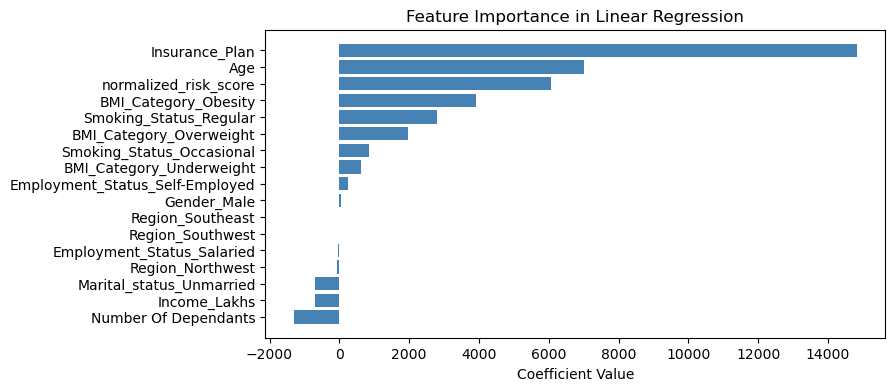

In [25]:
#Measuring the importance of each of the factors using a horizontal bar chart
feature_importance = lr_model.coef_

# Create a DataFrame for easier handling
coef_df = pd.DataFrame(feature_importance, index=X_train.columns, columns=['Coefficients'])

# Sort the coefficients for better visualization
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)

# Plotting
plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Linear Regression')
plt.show()

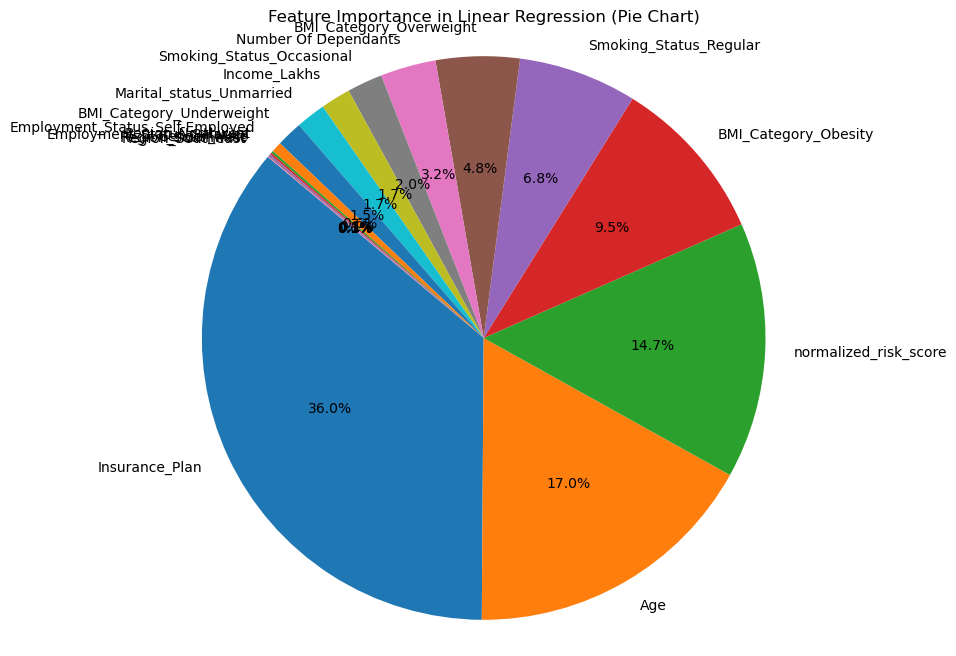

In [26]:
#Measuring the importance of each of the factors using a pie chart

import matplotlib.pyplot as plt

# Absolute coefficients as importance
feature_importance = abs(lr_model.coef_)

# Create DataFrame for plotting
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    coef_df['Importance'],
    labels=coef_df['Feature'],
    autopct='%1.1f%%',
    startangle=140
)
plt.title('Feature Importance in Linear Regression (Pie Chart)')
plt.axis('equal')  # Equal aspect ratio ensures a perfect circle
plt.show()


## Using Lasso and Ridge regression for different alpha values

In [27]:
alpha_values = [0.01, 0.1, 1]

# Define models and their parameter grids
model_params = {
    'Ridge': {
        'model': Ridge(),
        'params': {'alpha': alpha_values}
    },
    'Lasso': {
        'model': Lasso(max_iter=10000),
        'params': {'alpha': alpha_values}
    }
}

# Collect results
results = []

# Use R2 as scoring metric
scorer = make_scorer(r2_score)

# Loop through each model and perform GridSearchCV
for name, mp in model_params.items():
    clf = GridSearchCV(mp['model'], mp['params'], scoring=scorer, cv=5, return_train_score=False)
    clf.fit(X_train, y_train)

    for i in range(len(clf.cv_results_['params'])):
        alpha = clf.cv_results_['params'][i]['alpha']
        mean_r2 = clf.cv_results_['mean_test_score'][i]
        results.append((name, alpha, mean_r2))

# Convert to DataFrame with MultiIndex
df_results = pd.DataFrame(results, columns=["Regression", "Alpha", "R2 Score"])
df_results.set_index(["Regression", "Alpha"], inplace=True)

# Display the result
df_results

R2 Score
Regression Alpha          
Ridge      0.01   0.953304
           0.10   0.953304
           1.00   0.953304
Lasso      0.01   0.953304
           0.10   0.953304
           1.00   0.953302

## Using Decision Tree

In [28]:
# Define the depths you want to try
depths = [5, 10, 15, 20]
results = []

# Loop through each depth and evaluate R2 with cross-validation
for depth in depths:
    model = DecisionTreeRegressor(max_depth=depth, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    mean_r2 = scores.mean()
    results.append((depth, mean_r2))

# Create and format DataFrame
df_tree = pd.DataFrame(results, columns=["Max Depth", "R2 Score"])
df_tree.set_index("Max Depth", inplace=True)

# Display
df_tree


,R2 Score
Max Depth,
5,0.941946
10,0.997543
15,0.996729
20,0.996187


## Using XGBoost Regressor

In [29]:
# Parameter grid
model_xgb = XGBRegressor(n_estimators=20, max_depth=3)
model_xgb.fit(X_train, y_train)
model_xgb.score(X_test, y_test)


0.9948463439941406

In [30]:
model_xgb = XGBRegressor(tree_method='hist', verbosity=0)

# Smaller parameter grid
param_grid = {
    'n_estimators': [20, 50],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5]
}

# Random search with fewer combinations
random_search = RandomizedSearchCV(
    model_xgb,
    param_grid,
    n_iter=10,
    cv=3,
    scoring='r2',
    random_state=42,
    n_jobs=1
)

# Fit the model
random_search.fit(X_train, y_train)

# Print best score and parameters
print("Best R2 Score:", random_search.best_score_)
print("Best Params:", random_search.best_params_)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best R2 Score: 0.9970577955245972
Best Params: {'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1}


In [31]:
best_model = random_search.best_estimator_

## Error analysis

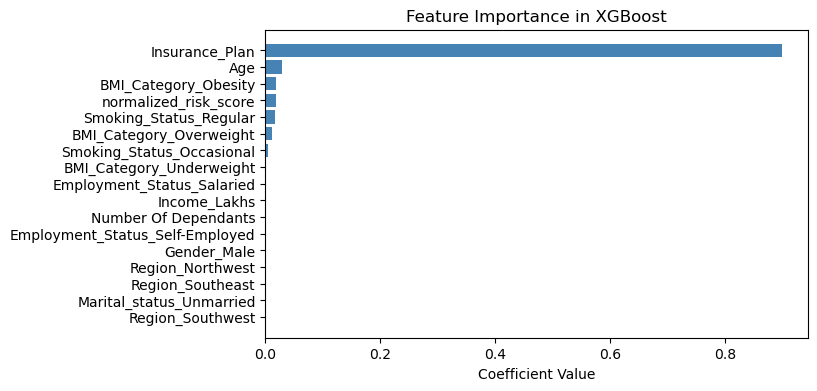

In [32]:
feature_importance = best_model.feature_importances_

# Create a DataFrame for easier handling
coef_df = pd.DataFrame(feature_importance, index=X_train.columns, columns=['Coefficients'])

# Sort the coefficients for better visualization
coef_df = coef_df.sort_values(by='Coefficients')

# Plotting
plt.figure(figsize=(7, 4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in XGBoost')
plt.show()

In [33]:
y_pred = best_model.predict(X_test)

residuals = y_pred - y_test
residuals_pct = (residuals / y_test) * 100

results_df = pd.DataFrame({
    'Actual Value': y_test, 
    'Predicted Value': y_pred, 
    'Difference in Values': residuals, 
    'Percentage Difference in Values': residuals_pct
})
results_df.head()

,Actual Value,Predicted Value,Difference in Values,Percentage Difference in Values
19713,26895,26691.470703,-203.529297,-0.756755
14750,22734,22650.751953,-83.248047,-0.366183
19932,21198,21581.894531,383.894531,1.810994
29643,9100,9425.934570,325.934570,3.581699
17076,26434,26691.470703,257.470703,0.974013


In [34]:
extreme_error_threshold = 10  
extreme_results_df = results_df[np.abs(results_df['Percentage Difference in Values']) > extreme_error_threshold]
extreme_results_df.head()

,Actual Value,Predicted Value,Difference in Values,Percentage Difference in Values
14286,6845,7621.263672,776.263672,11.340594
27518,8502,9425.934570,923.934570,10.867261
9285,6872,7621.263672,749.263672,10.903138
7547,6538,7621.263672,1083.263672,16.568732
21910,6651,7621.263672,970.263672,14.588237


In [35]:
extreme_errors_pct = extreme_results_df.shape[0]*100/X_test.shape[0]
extreme_errors_pct

0.32413099362914943

We have 30% extreme errors which means for 30% customers we will either overcharge or undercharge by 10% or more

In [36]:
extreme_results_df[abs(extreme_results_df['Percentage Difference in Values'])>50].sort_values("Percentage Difference in Values",ascending=False)

,Actual Value,Predicted Value,Difference in Values,Percentage Difference in Values


In [37]:
extreme_errors_df = X_test.loc[extreme_results_df.index]
extreme_errors_df.head(2)

,Age,Number Of Dependants,Income_Lakhs,Insurance_Plan,normalized_risk_score,Gender_Male,Region_Northwest,Region_Southeast,Region_Southwest,Marital_status_Unmarried,BMI_Category_Obesity,BMI_Category_Overweight,BMI_Category_Underweight,Smoking_Status_Occasional,Smoking_Status_Regular,Employment_Status_Salaried,Employment_Status_Self-Employed
14286,0.021739,0.6,0.050505,0.0,0.000000,1,1,0,0,1,0,0,0,0,0,1,0
27518,0.304348,0.6,0.080808,0.0,0.357143,1,1,0,0,0,0,0,0,0,0,0,1
